# Style Transfer notebook
## CS152 Jason Yi

In [1]:
# Get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# The main external libraries needed
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path

/home/jyi20/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Define the path
PATH = Path('../image')
ARCH=vgg16
sz=288

## Utility Functions

In [4]:
def denorm(tensor, denormalizer):
    # Deals with the normalization involving mean and standard deviation
    
    # Even though the transformer returned from tfms_from_model moves the channels
    # (from width, height, depth) to (1, channels, width, height), the denormalizer
    # returned from tfms_from_model doesn't convert back
    
    # Moves the axes
    wid_height_depth = np.moveaxis(to_np(tensor),1,-1)[0]
    return denormalizer(wid_height_depth)

In [5]:
# Draw image with particular size
def draw_with_size(image, size_in_inches):
    plt.figure(figsize=(size_in_inches, size_in_inches))
    plt.imshow(image);

In [6]:
# Create random image based on given shape (tuple) thats coming in. Essentially creating random white noise
def random_image(shape):
    return np.random.uniform(0, 1, size=shape).astype(np.float32)

In [7]:
# Scaling because the content and style image may not be the same size. 
# We want the style image to be at least as big as content image. Maintains aspect ratio.
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    ratio = max(h/sh,w/sw);
    res = cv2.resize(targ, (int(sw*ratio), int(sh*ratio)))
    return res[:h,:w]

In [8]:
# Arch is our vgg16 model and true allows it to be pretrained
ARCH=vgg16
model_full = to_gpu(ARCH(True)).eval()
# Don't want it to be trainable with false
set_trainable(model_full, False)

## Incorporate scaling factor for style loss

We will now retrieve our content image.

Text(0.5, 1.0, 'content image')

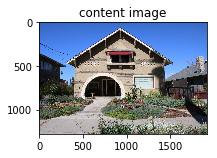

In [9]:
# Set the content image to the house
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

We will now retrieve our style image.

Text(0.5, 1.0, 'style image')

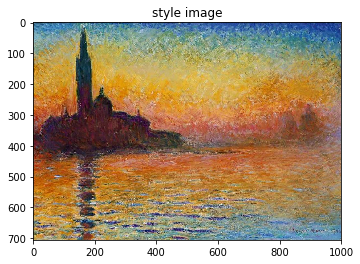

In [10]:
# Get the style image
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [11]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# transform the content image
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

We will now create our random image.

Text(0.5, 1.0, 'initialization image')

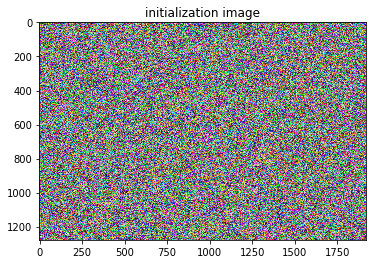

In [12]:
# opt_img is now our random image (noise) that has the same size as content image
opt_img = random_image(content_img.shape)
plt.imshow(opt_img);
plt.title("initialization image")

In [13]:
# Save the features.
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [14]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [15]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is LBFGS in this case"""
    opt_img = random_image(content_img.shape)
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [16]:
def comb_loss(x):
    """This is the combination of the content loss and style loss. We also incorporate the scale factor
        into the mean square loss for this case."""
    model_full(opt_img_v)
    scale_fac = [4,1,1,2,4]
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s)*x for o,s,x in zip(outs, targ_styles, scale_fac)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [17]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [18]:
def gram(input):
    """Split up image and use pointwise multiplication"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [19]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=1000
# Apply step function using loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 1520.333984375
Iteration: 200, loss: 744.4163818359375
Iteration: 300, loss: 561.582763671875
Iteration: 400, loss: 476.7587585449219
Iteration: 500, loss: 427.84698486328125
Iteration: 600, loss: 395.02093505859375
Iteration: 700, loss: 370.8310241699219
Iteration: 800, loss: 352.9613952636719
Iteration: 900, loss: 339.2955017089844
Iteration: 1000, loss: 328.8646240234375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


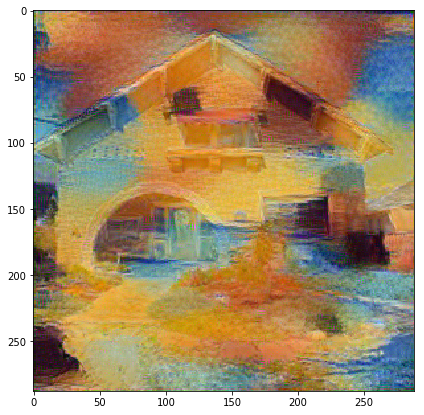

In [20]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Different Style image with same Content

We will first retrieve our content image.

Text(0.5, 1.0, 'content image')

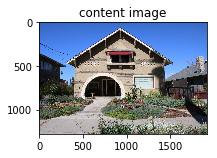

In [21]:
# Set the content image to the house
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

We will now retrieve our style image.

Text(0.5, 1.0, 'style image')

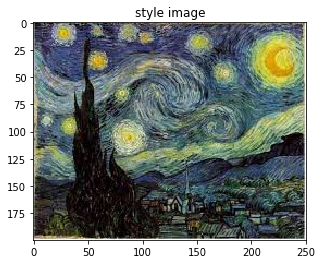

In [22]:
# Get the style image
MONET = 'vangogh.jpeg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [23]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# give the content image and get the shape
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

We now create our random image.

Text(0.5, 1.0, 'initialization image')

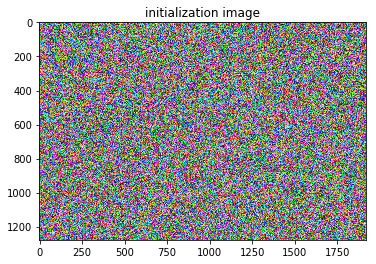

In [24]:
# opt_img is now our random image (noise) that has the same size as content image
opt_img = random_image(content_img.shape)
plt.imshow(opt_img);
plt.title("initialization image")

In [25]:
# Save the features.
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [26]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [27]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is LBFGS in this case"""
    opt_img = random_image(content_img.shape)
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [28]:
def comb_loss(x):
    """This is the combination of the content loss and style loss. """
    model_full(opt_img_v)
    scale_fac = [4,1,1,2,4]
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s)*x for o,s,x in zip(outs, targ_styles, scale_fac)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [29]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [30]:
def gram(input):
    """Split up image and use pointwise multiplication"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [31]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=1000
# Apply step function using loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 4173.74169921875
Iteration: 200, loss: 2072.087890625
Iteration: 300, loss: 1395.026611328125
Iteration: 400, loss: 1052.9925537109375
Iteration: 500, loss: 872.5316162109375
Iteration: 600, loss: 772.7777709960938
Iteration: 700, loss: 710.4760131835938
Iteration: 800, loss: 666.451416015625
Iteration: 900, loss: 632.9052124023438
Iteration: 1000, loss: 606.3551025390625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


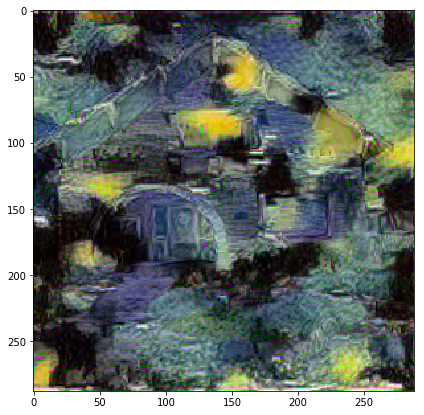

In [32]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Different Content image with same style

We retreive the content image.

Text(0.5, 1.0, 'content image')

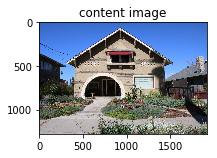

In [33]:
# Set the content image to a new image, city
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

We retrieve the style image.

Text(0.5, 1.0, 'style image')

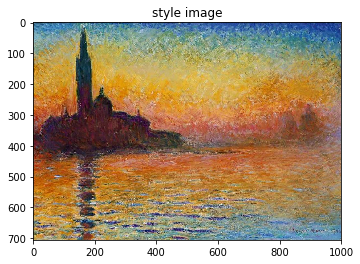

In [34]:
# Get the style image
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [35]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# give the content image and get the shape
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

We create random image.

Text(0.5, 1.0, 'initialization image')

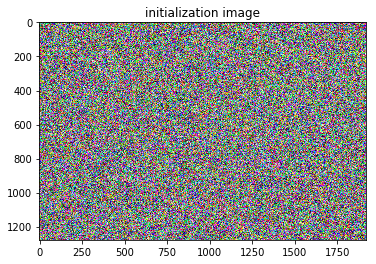

In [36]:
# opt_img is now our random image (noise) that has the same size as content image
opt_img = random_image(content_img.shape)
plt.imshow(opt_img);
plt.title("initialization image")

In [37]:
# Save the Features
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [38]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [39]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is LBFGS in this case"""
    opt_img = random_image(content_img.shape)
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [40]:
def comb_loss(x):
    """This is the combination of the content loss and style loss."""
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [41]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [42]:
def gram(input):
    """Get the loss of the gram matrix of mean square error"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [43]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=1000
# Apply step function using loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 813.76318359375
Iteration: 200, loss: 438.2702331542969
Iteration: 300, loss: 348.3215026855469
Iteration: 400, loss: 308.6521301269531
Iteration: 500, loss: 285.80511474609375
Iteration: 600, loss: 270.9913330078125
Iteration: 700, loss: 260.75946044921875
Iteration: 800, loss: 253.05458068847656
Iteration: 900, loss: 247.21261596679688
Iteration: 1000, loss: 242.76278686523438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


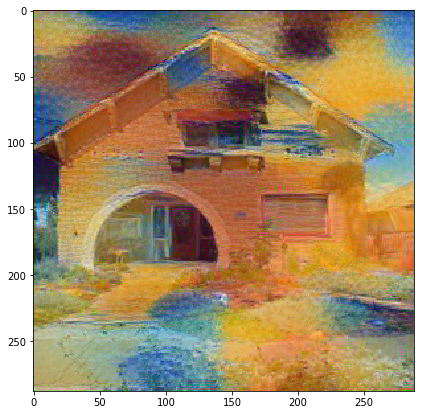

In [44]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Different Optimizer: Adam

We now create an image that is close to the content of the content image, while also close to the style of the style image.


Text(0.5, 1.0, 'content image')

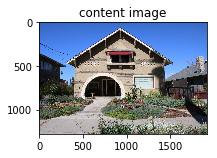

In [45]:
# Set the content image to the house
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

We now retrieve the style image.

Text(0.5, 1.0, 'style image')

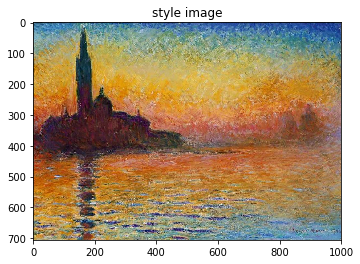

In [46]:
# Get the style image
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [47]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# give the content image and get the shape
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

Text(0.5, 1.0, 'initialization image')

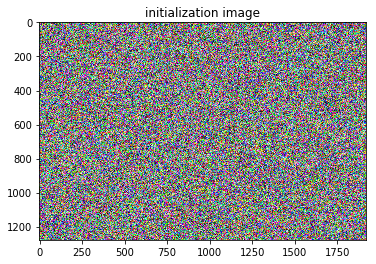

In [48]:
# opt_img is now our random image (noise) that has the same size as content image
opt_img = random_image(content_img.shape)
plt.imshow(opt_img);
plt.title("initialization image")

In [49]:
# Save the features
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [50]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [51]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is Adam in this case"""
    opt_img = random_image(content_img.shape)
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.Adam([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [52]:
def comb_loss(x):
    """This is the combination of the content loss and style loss."""
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [53]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [54]:
def gram(input):
    """Split up image and use pointwise multiplication"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [55]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=1000
# Apply step function using the loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 1107.9849853515625
Iteration: 200, loss: 682.2398071289062
Iteration: 300, loss: 517.8132934570312
Iteration: 400, loss: 441.5106201171875
Iteration: 500, loss: 82202.625
Iteration: 600, loss: 597.167236328125
Iteration: 700, loss: 417.69012451171875
Iteration: 800, loss: 366.47412109375
Iteration: 900, loss: 340.3792724609375
Iteration: 1000, loss: 321.35076904296875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


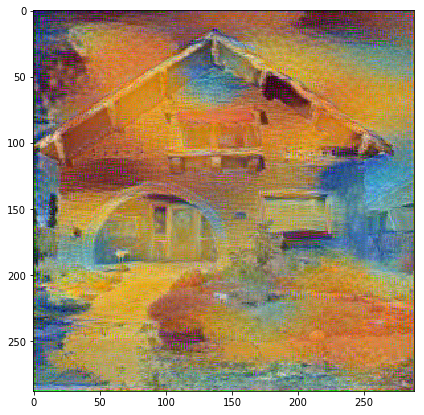

In [56]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Initialize with content image

We retrieve the content image.

Text(0.5, 1.0, 'content image')

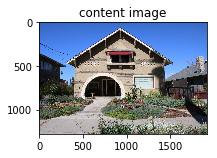

In [57]:
# Set the content image to the house
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

We now retrieve the style image.

Text(0.5, 1.0, 'style image')

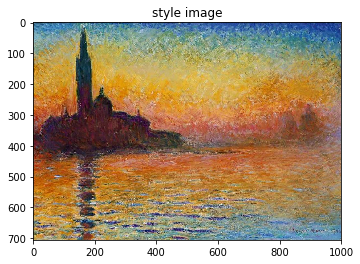

In [58]:
# Get the style image
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [59]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# give the content image and get the shape
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

Initialize with the content image.

Text(0.5, 1.0, 'initialization image')

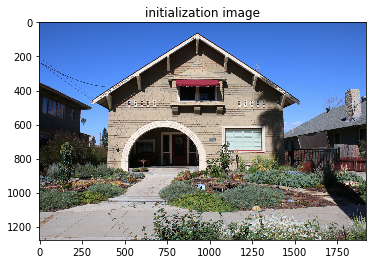

In [60]:
# opt_img is now our content image
opt_img = content_img
plt.imshow(opt_img);
plt.title("initialization image")

In [61]:
# Save the features
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [62]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [63]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is LBFGS in this case"""
    opt_img = content_img
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [64]:
def comb_loss(x):
    """This is the combination of the content loss and style loss."""
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [65]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [66]:
def gram(input):
    """Split up image and use pointwise multiplication"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [67]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=1000
# Apply step function using loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 333.52716064453125
Iteration: 200, loss: 257.7890930175781
Iteration: 300, loss: 234.10032653808594
Iteration: 400, loss: 222.89663696289062
Iteration: 500, loss: 216.78994750976562
Iteration: 600, loss: 212.89407348632812
Iteration: 700, loss: 210.0689697265625
Iteration: 800, loss: 207.85791015625
Iteration: 900, loss: 206.21444702148438
Iteration: 1000, loss: 204.83743286132812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


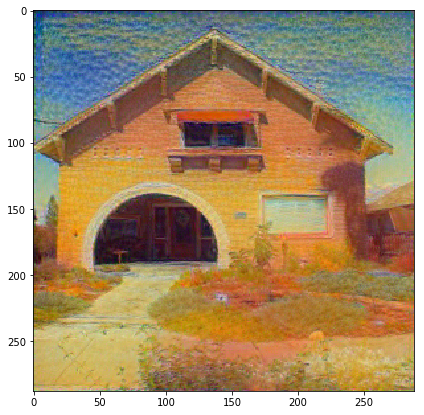

In [68]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Initialize with style image

We retrieve the content image.

Text(0.5, 1.0, 'content image')

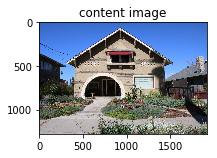

In [69]:
# Set the content image to the house
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

Retrieve the style image.

Text(0.5, 1.0, 'style image')

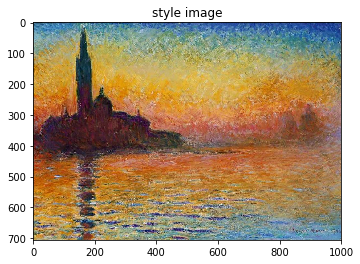

In [70]:
# Get the style image
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [71]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# give the content image and get the shape
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

initialize with the style image

Text(0.5, 1.0, 'initialization image')

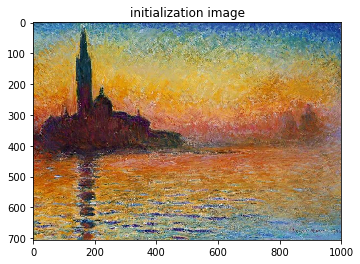

In [72]:
# opt_img is now set as the style image
opt_img = style_img
plt.imshow(opt_img);
plt.title("initialization image")

In [73]:
# save features
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [74]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [75]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is LBFGS in this case"""
    opt_img = style_img
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [76]:
def comb_loss(x):
    """This is the combination of the content loss and style loss."""
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [77]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [78]:
def gram(input):
    """Split up image and use pointwise multiplication"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): 
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [79]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=1000
# Apply step function using content loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 426.7342834472656
Iteration: 200, loss: 314.42333984375
Iteration: 300, loss: 272.4084777832031
Iteration: 400, loss: 252.14138793945312
Iteration: 500, loss: 240.7659912109375
Iteration: 600, loss: 233.69190979003906
Iteration: 700, loss: 228.84307861328125
Iteration: 800, loss: 225.25311279296875
Iteration: 900, loss: 222.31231689453125
Iteration: 1000, loss: 219.9599609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


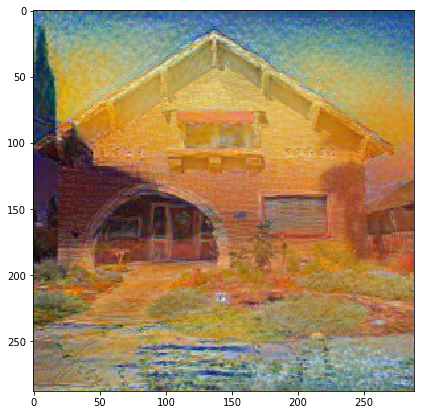

In [80]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Best Image (Learning Rate + Optimization Steps + Scaling Factor + Optimizer)

Retrieve the content image.

Text(0.5, 1.0, 'content image')

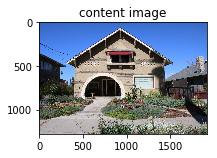

In [81]:
# Set the content image to the house
HOUSE = 'house.png'
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)
plt.title("content image")

Retrieve the style image.

Text(0.5, 1.0, 'style image')

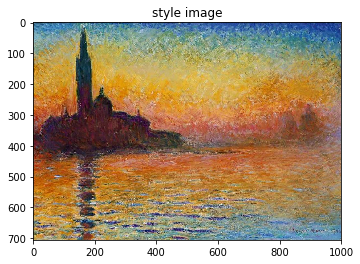

In [82]:
# Get the style image
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);
plt.title("style image")

In [83]:
# Get the training and validation
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
# give the content image and get the shape
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

Our initialization image is now set to the content image.

Text(0.5, 1.0, 'initialization image')

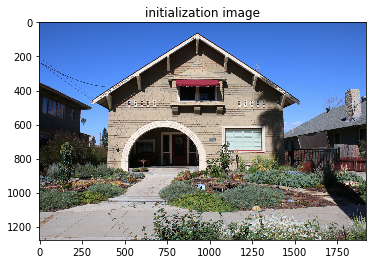

In [84]:
# opt_img is now the content image
opt_img = content_img
plt.imshow(opt_img);
plt.title("initialization image")

In [85]:
# Save Features.
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

Get the layers before maxpooling and run the model for content and style.

In [86]:
# gets the layers before maxpooling
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

# save the features
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

# run model for content and create variable
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

# run model for style and create variable
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [87]:
def get_opt():
    """"Gets the Image to optimize and the optimizer which is LBFGS in this case"""
    opt_img = content_img
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.8)
opt_img_v, optimizer = get_opt()

We now create a combined loss function for both the content and style.  

In [88]:
def comb_loss(x):
    """This is the combination of the content loss and style loss."""
    model_full(opt_img_v)
    scale_fac = [4,1,1,2,4]
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s)*x for o,s,x in zip(outs, targ_styles, scale_fac)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [89]:
# this is where we backpropagate with the given loss function
def step(loss_fn):
    """This is where we use the optimizer and find the loss. Then with the given loss, we backpropagate"""
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [90]:
def gram(input):
    """Split up image and use pointwise multiplication"""
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target):
    """Get the loss of the gram matrix of mean square error"""
    return F.mse_loss(gram(input), gram(target))

In [91]:
# running the optimizer for 1000 iterations
n_iter=0
show_iter = 100
max_iter=2000
# Apply step function using loss we defined
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 515.2979125976562
Iteration: 200, loss: 357.75531005859375
Iteration: 300, loss: 308.8870849609375
Iteration: 400, loss: 284.1219482421875
Iteration: 500, loss: 269.5735778808594
Iteration: 600, loss: 260.2368469238281
Iteration: 700, loss: 254.02099609375
Iteration: 800, loss: 249.55616760253906
Iteration: 900, loss: 246.22061157226562
Iteration: 1000, loss: 243.66162109375
Iteration: 1100, loss: 241.64089965820312
Iteration: 1200, loss: 240.03265380859375
Iteration: 1300, loss: 238.6663818359375
Iteration: 1400, loss: 237.5232696533203
Iteration: 1500, loss: 236.54888916015625
Iteration: 1600, loss: 235.6768341064453
Iteration: 1700, loss: 234.89309692382812
Iteration: 1800, loss: 234.20314025878906
Iteration: 1900, loss: 233.59515380859375
Iteration: 2000, loss: 233.04766845703125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


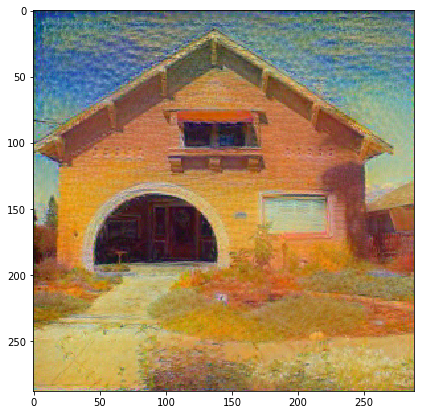

In [92]:
# pull out of our variable the data and denormalize it
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)